In [ ]:
%load_ext autoreload
%autoreload 2

from generative import dataset, utils, models
import jax
import jax.numpy as jnp
import optax
import orbax.checkpoint
from flax.training import orbax_utils
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct 

from tqdm import tqdm

In [ ]:
model = models.VAE()
dummy_input = jnp.zeros((1, 28, 28, 3))

kl_multiplier = 0.01

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')
  kl_loss: metrics.Average.from_output('kl_loss')
  reconstruction_loss: metrics.Average.from_output('reconstruction_loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

# Initialize the parameters, optimizer, etc.
def create_train_state(module, rng, learning_rate, dummy_input):
  rng1, rng2 = jax.random.split(rng)
  rngs = {'params': rng1, 'noise': rng2}
  params = module.init(rngs, dummy_input)['params'] # initialize parameters by passing a template image
  tx = optax.adam(learning_rate)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

# One step of training.
@jax.jit
def train_step(state, images, labels, rng):
    # Run the model forward one step. Using params.
    def loss_fn(params):
        model_output, mean, std = state.apply_fn({'params': params}, images, rngs={'noise': rng})
        kl_loss = 0.5 * (jnp.square(mean) + jnp.square(std) - jnp.log(1e-8 + jnp.square(std)) - 1.0).mean()
        reconstruction_loss = optax.l2_loss(model_output, images).mean()
        loss = reconstruction_loss + kl_loss*kl_multiplier
        return loss, (kl_loss, reconstruction_loss)
    # Compute gradient and apply an optimization step.
    grad_fn = jax.grad(loss_fn, has_aux=True)
    grads, _ = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    # Log metrics. (This is inefficient but for sanity purposes)
    loss, (kl_loss, reconstruction_loss) = loss_fn(state.params)
    metric_updates = state.metrics.single_from_model_output(loss=loss, kl_loss=kl_loss, reconstruction_loss=reconstruction_loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

# Evaluation.
def pred_step(state, rng, batch_size):
	rng1, rng2 = jax.random.split(rng)
	char_set = dataset.mnist_char_set()
	images, labels = dataset.mnist_colored(char_set, rng1, batch_size=batch_size)
	model_output, _, _ = state.apply_fn({'params': state.params}, images, rngs={'noise': rng2})

	# utils.plot_image_row(images[:16])
	return model_output

# Evaluation.
def gen_step(state, rng, batch_size):
    z = jax.random.normal(rng, shape=(batch_size, 16))
    model_output = state.apply_fn({'params': state.params}, z, method='decode')
    return model_output

In [ ]:
# TRAINING LOOP

global_rng = jax.random.PRNGKey(0)
sub_rng, global_rng = jax.random.split(global_rng)
state = create_train_state(model, sub_rng, 3e-4, dummy_input=dummy_input)

char_set = dataset.mnist_char_set()

for step in tqdm(range(100*1000)):
    sub_rng, global_rng = jax.random.split(global_rng)
    images, labels = dataset.mnist_colored(char_set, sub_rng, batch_size=64)

    # Run a training step. Then, run again to compute metrics.
    sub_rng, global_rng = jax.random.split(global_rng)
    state = train_step(state, images, labels, sub_rng)

    if step % 250 == 0:
        for metric, value in state.metrics.compute().items(): # compute metrics
            tqdm.write(f'[{step//50}] {metric}: {value:.4f}')
        state = state.replace(metrics=state.metrics.empty())

    if step % 500 == 0:
        sub_rng, global_rng = jax.random.split(global_rng)
        model_output = pred_step(state, sub_rng, batch_size=32)
        utils.plot_image_row(model_output[:8])

ckpt = {'model': state}
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('saves/vae/', ckpt, save_args=save_args)

In [ ]:
# Restore model into 'state'
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
global_rng = jax.random.PRNGKey(0)
sub_rng, global_rng = jax.random.split(global_rng)
state_template = create_train_state(model, sub_rng, 3e-4, dummy_input=dummy_input)
ckpt_template = {'model': state_template}
ckpt = orbax_checkpointer.restore('saves/vae/', item=ckpt_template)
state = ckpt['model']

In [ ]:
# Charts for Ground Truth Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = dataset.mnist_colored(char_set, sub_rng, batch_size=128)[0]
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

In [ ]:
# Charts for Generated Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = gen_step(state, sub_rng, batch_size=128)
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

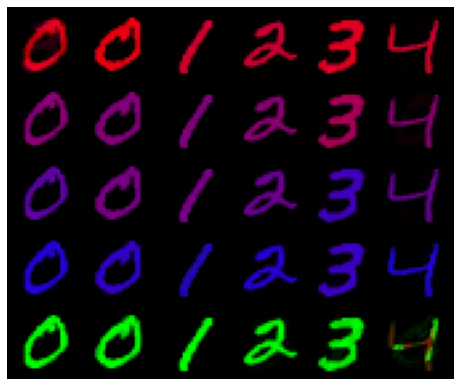

In [14]:
utils.plot_examples_table(examples_table)